<a href="https://colab.research.google.com/github/AzulEye/VAE_MNIST_Clock/blob/master/VAE_MNIST_Clock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import randn
from time import sleep
mode = 'sampling'
bs = 200

In [2]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!





In [0]:

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


In [0]:
# build model
VAEs = []
optimizers = []
for i in range(10):
    VAEs.append(VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=10).cuda())



    optimizers.append(optim.Adam(VAEs[i].parameters()))
    # return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
def train(epoch,cat):
    VAEs[cat].train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        inds = (label == cat).nonzero().squeeze()
        data = data[inds].cuda()
        optimizers[cat].zero_grad()

        recon_batch, mu, log_var = VAEs[cat](data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizers[cat].step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    torch.save(VAEs[cat].state_dict(), 'vae' + str(cat) + '.pt')


def test():
    for i in range(10):
        VAEs[i].eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.cuda()
                recon, mu, log_var = VAEs[i](data)

                # sum up batch loss
                test_loss += loss_function(recon, data, mu, log_var).item()

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

# for i in range(10):
#     VAEs[i].load_state_dict(torch.load('vae' + str(i) + '.pt'))
for e in range(3):
    for c in range(10):
        train(e,c)
    # test()
# torch.save(vae.state_dict(),'vae.pt')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 543.917271
Train Epoch: 0 [2200/60000 (33%)]	Loss: 183.972334
Train Epoch: 0 [4400/60000 (67%)]	Loss: 151.056263
====> Epoch: 0 Average loss: 17.8221
Train Epoch: 0 [0/60000 (0%)]	Loss: 545.236230
Train Epoch: 0 [2300/60000 (33%)]	Loss: 83.228218
Train Epoch: 0 [4800/60000 (67%)]	Loss: 61.553080
====> Epoch: 0 Average loss: 10.0521
Train Epoch: 0 [0/60000 (0%)]	Loss: 543.786707
Train Epoch: 0 [2200/60000 (33%)]	Loss: 199.364014
Train Epoch: 0 [3600/60000 (67%)]	Loss: 186.241618
====> Epoch: 0 Average loss: 19.8877
Train Epoch: 0 [0/60000 (0%)]	Loss: 545.621722
Train Epoch: 0 [2900/60000 (33%)]	Loss: 168.501717
Train Epoch: 0 [4000/60000 (67%)]	Loss: 160.084619
====> Epoch: 0 Average loss: 18.9644
Train Epoch: 0 [0/60000 (0%)]	Loss: 545.066096
Train Epoch: 0 [1200/60000 (33%)]	Loss: 176.958211
Train Epoch: 0 [4400/60000 (67%)]	Loss: 157.370683
====> Epoch: 0 Average loss: 16.7218
Train Epoch: 0 [0/60000 (0%)]	Loss: 544.031390
Train Epoch: 0 [1600/6000

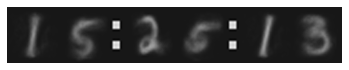

KeyboardInterrupt: ignored

In [21]:

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import torchvision
plt.ion()
import datetime

colonIm = np.zeros((28,8))
colonIm[7:11,2:6] = 1
colonIm[17:21,2:6] = 1

print('')
OldZ = [None]*10
OldZ2 = [None]*6
with torch.no_grad():
    z = torch.randn(6, 2).cuda()
    while(True):
        for batch_idx, (data, label) in enumerate(train_loader):

            now = datetime.datetime.now()
            h = now.hour
            m = now.minute
            s = now.second
            DIGITS = [h/10,h%10,m/10,m%10,s/10,s%10]
            # print(DIGITS)
            DIGITS_IMS = []



            for d in range(len(DIGITS)):
                # print(z)
                if (mode == 'interpolation'):
                    inds = (label==DIGITS[d]).nonzero()
                    ind = inds[np.random.randint(len(inds)),0]
                    ind2 = inds[np.random.randint(len(inds)),0]
                    mean,std = VAEs[int(DIGITS[d])].encoder(data[ind].reshape((-1,28*28)).cuda())
                    mean2,std2 = VAEs[int(DIGITS[d])].encoder(data[ind2].reshape((-1,28*28)).cuda())
                    zreal2 = VAEs[int(DIGITS[d])].sampling(mean2, std2)
                    if (OldZ[int(DIGITS[d])] is None):

                        zreal = VAEs[int(DIGITS[d])].sampling(mean, std)
                        OldZ[int(DIGITS[d])] = zreal2
                    else:
                        zreal = OldZ[int(DIGITS[d])]
                        OldZ[int(DIGITS[d])] = zreal2
                    # z = torch.randn(1, 2).cuda()

                else:
                    zreal2 = torch.randn(1, 10).cuda()
                    if (OldZ2[d] is None):
                        zreal = torch.randn(1, 10).cuda()

                    else:
                        zreal = OldZ2[d]


                n = (torch.randn(1, 10) * 0.1).cuda()
                rand0_1 = 0.2 #the smaller it is the shorter the random walk step
                z = (1-rand0_1)*zreal + rand0_1*zreal2
                # z = zreal + (rand0_1 * zreal2)
                OldZ2[d] = z
                sample = VAEs[int(DIGITS[d])].decoder(z).cuda()
                IM = sample.view(28, 28).cpu().numpy()
                DIGITS_IMS.append(IM)
                if (len(DIGITS_IMS) in [2,5,6]):
                    DIGITS_IMS.append(colonIm)
            mosaic = np.concatenate(DIGITS_IMS,1)
            IM = cv2.resize(mosaic, dsize=(250*6, 250), interpolation=cv2.INTER_CUBIC)





            #plotting option for colab - suboptimal (comment if working with local python environment)
            clear_output()
            plt.imshow(IM,cmap='gray')
            plt.axis('off')
            plt.show()
            sleep(2)

            #plotting option for with local python environment (uncomment if working with local python environment)
            # cv2.imshow('image', IM)
            # cv2.waitKey(1)
            
            
